# 10.1b: Lattice Width Analysis

**How many cells wide is the crystal in each dimension?**

## The Question

From 10.1a, we know:
- 195 binary dimensions (2 unique values)
- 1,069 ternary dimensions (3 unique values)
- 917 highly active dimensions (4+ unique values)

But what does "4+ values" actually mean in terms of **lattice cells**?

## Lattice Cells vs Unique Values

If a dimension has:
- **2 unique values** → spans **1 cell** (two grid points)
- **3 unique values** → spans **2 cells** (three grid points)
- **N unique values** → spans **N-1 cells**

But we need to be careful: the unique values might not be evenly spaced!

## Better Metric: Range in ULPs

For each dimension:
1. Compute the **scale** (typical magnitude of values)
2. Compute **ULP** at that scale
3. Compute **range / ULP** = lattice width in cells

This tells us the true width of the crystal in bfloat16 lattice units.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

LATTICE_BASIS_FILE = "lattice_basis.safetensors"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading crystal vectors...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Crystal size: {n_vectors:,} vectors")
print(f"  Dimensions:   {d:,}")
print()

print("Loading lattice basis info...")
basis_data = load_file(data_dir / LATTICE_BASIS_FILE)
dim_range = basis_data["dim_range"]
dim_n_unique = basis_data["dim_n_unique"]
is_active = ~basis_data["is_frozen"]

print(f"  Active dimensions: {is_active.sum().item():,}")
print()

print("✓ Data loaded")

Loading crystal vectors...
  Crystal size: 124 vectors
  Dimensions:   2,560

Loading lattice basis info...
  Active dimensions: 2,181

✓ Data loaded


## Compute Dimension-wise ULP

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

print("Computing ULP for each dimension...\n")

# For each dimension, use the mean absolute value as the scale
dim_scale = vectors.abs().mean(dim=0)

# Compute ULP at that scale
dim_ulp = torch.zeros(d)
for i in range(d):
    dim_ulp[i] = bfloat16_ulp(dim_scale[i].item())

print(f"ULP statistics:")
print(f"  Min:    {dim_ulp.min().item():.6e}")
print(f"  Max:    {dim_ulp.max().item():.6e}")
print(f"  Mean:   {dim_ulp.mean().item():.6e}")
print(f"  Median: {dim_ulp.median().item():.6e}")
print()

print("✓ ULP computed for all dimensions")

Computing ULP for each dimension...

ULP statistics:
  Min:    1.490116e-08
  Max:    2.441406e-04
  Mean:   1.331615e-05
  Median: 7.629395e-06

✓ ULP computed for all dimensions


## Compute Lattice Width (Range / ULP)

In [5]:
print("Computing lattice width in cells...\n")

# Width in cells = range / ULP
# Add small epsilon to avoid division by zero
lattice_width = dim_range / (dim_ulp + 1e-100)

# For frozen dimensions, width = 0
lattice_width[~is_active] = 0

print(f"Lattice width statistics (active dimensions only):")
active_widths = lattice_width[is_active]
print(f"  Min:    {active_widths.min().item():.2f} cells")
print(f"  Max:    {active_widths.max().item():.2f} cells")
print(f"  Mean:   {active_widths.mean().item():.2f} cells")
print(f"  Median: {active_widths.median().item():.2f} cells")
print()

print("✓ Lattice width computed")

Computing lattice width in cells...

Lattice width statistics (active dimensions only):
  Min:    0.94 cells
  Max:    3072.00 cells
  Mean:   16.22 cells
  Median: 4.00 cells

✓ Lattice width computed


## Distribution of Lattice Widths

In [6]:
print("Analyzing distribution of lattice widths...\n")

# Round to nearest integer
lattice_width_rounded = torch.round(lattice_width[is_active]).long()

# Count occurrences
unique_widths, counts = torch.unique(lattice_width_rounded, return_counts=True)

# Sort by width
sorted_indices = torch.argsort(unique_widths)
unique_widths_sorted = unique_widths[sorted_indices]
counts_sorted = counts[sorted_indices]

total_active = is_active.sum().item()

print("Distribution of lattice widths (in cells):")
print()
print("  Width | Count      | Fraction")
print("-" * 40)

for i in range(len(unique_widths_sorted)):
    width = unique_widths_sorted[i].item()
    count = counts_sorted[i].item()
    fraction = 100 * count / total_active
    
    print(f"  {width:4d}  | {count:10,} | {fraction:6.2f}%")

print()
print("✓ Distribution analysis complete")

Analyzing distribution of lattice widths...

Distribution of lattice widths (in cells):

  Width | Count      | Fraction
----------------------------------------
     1  |         95 |   4.36%
     2  |        441 |  20.22%
     3  |        144 |   6.60%
     4  |        480 |  22.01%
     5  |        112 |   5.14%
     6  |        132 |   6.05%
     7  |          3 |   0.14%
     8  |        239 |  10.96%
     9  |         17 |   0.78%
    10  |         53 |   2.43%
    11  |         23 |   1.05%
    12  |         47 |   2.15%
    13  |          3 |   0.14%
    14  |          2 |   0.09%
    15  |          1 |   0.05%
    16  |        105 |   4.81%
    17  |          3 |   0.14%
    18  |          4 |   0.18%
    19  |          2 |   0.09%
    20  |         25 |   1.15%
    21  |          1 |   0.05%
    22  |         11 |   0.50%
    23  |          1 |   0.05%
    24  |         35 |   1.60%
    25  |          1 |   0.05%
    26  |          1 |   0.05%
    32  |         58 |   2.66%
 

## Visualizations

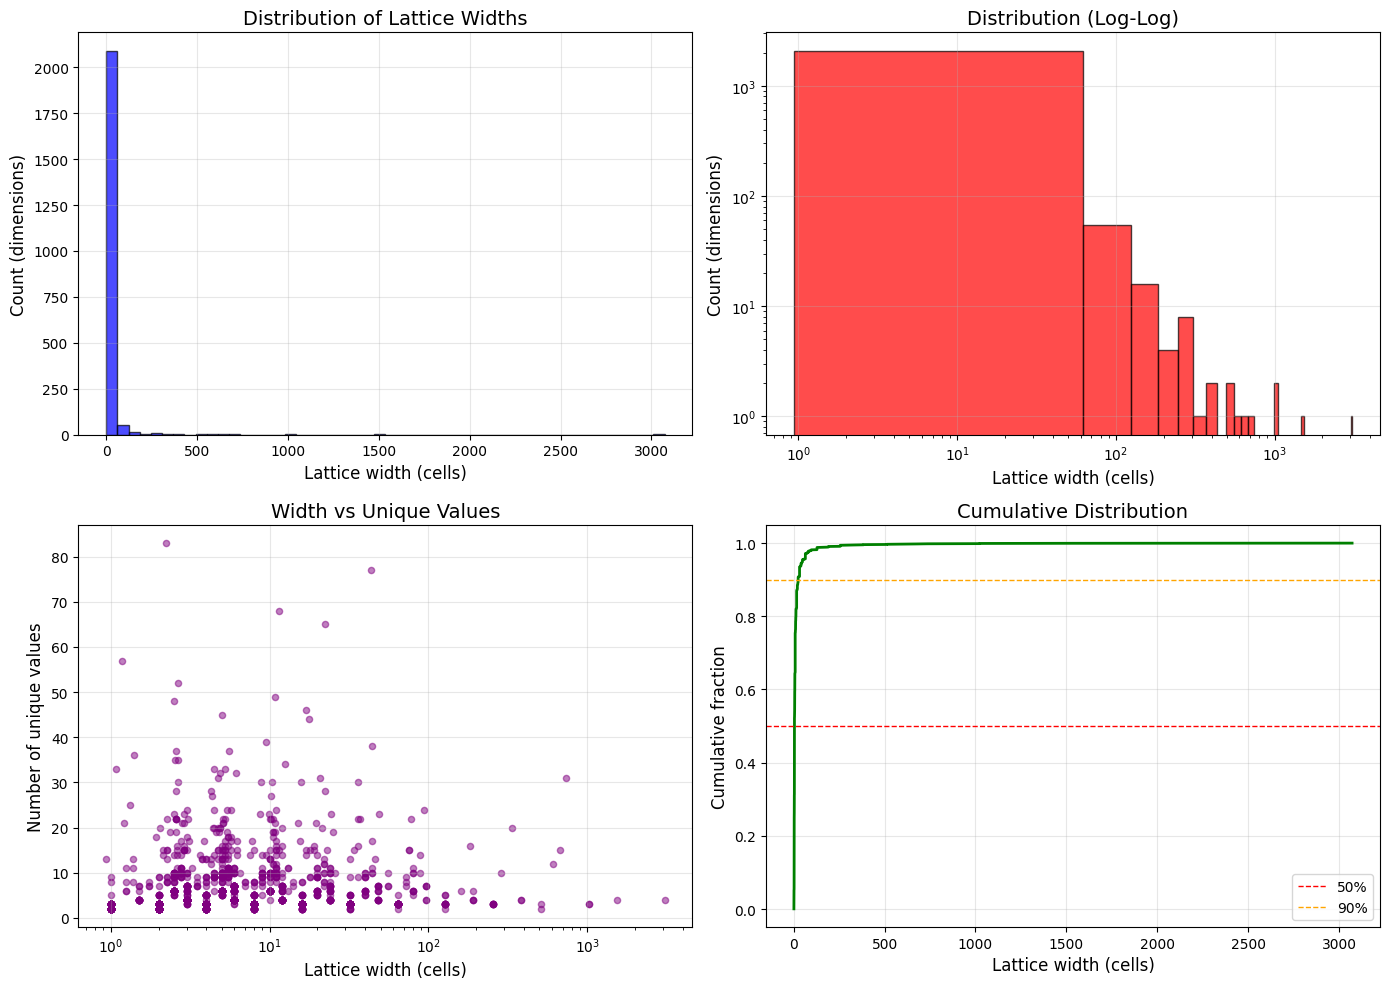

✓ Visualizations complete


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

active_widths_np = active_widths.cpu().numpy()

# Panel 1: Histogram of lattice widths
ax = axes[0, 0]
ax.hist(active_widths_np, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Lattice Widths', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 2: Log-scale histogram
ax = axes[0, 1]
ax.hist(active_widths_np, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 3: Width vs unique values
ax = axes[1, 0]
scatter_data = [(lattice_width[i].item(), dim_n_unique[i].item()) 
                for i in range(d) if is_active[i]]
if scatter_data:
    x, y = zip(*scatter_data)
    ax.scatter(x, y, alpha=0.5, s=20, color='purple')
    ax.set_xlabel('Lattice width (cells)', fontsize=12)
    ax.set_ylabel('Number of unique values', fontsize=12)
    ax.set_title('Width vs Unique Values', fontsize=14)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

# Panel 4: CDF of lattice widths
ax = axes[1, 1]
widths_sorted = np.sort(active_widths_np)
cdf = np.arange(1, len(widths_sorted) + 1) / len(widths_sorted)
ax.plot(widths_sorted, cdf, linewidth=2, color='green')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Cumulative fraction', fontsize=12)
ax.set_title('Cumulative Distribution', fontsize=14)
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50%')
ax.axhline(0.9, color='orange', linestyle='--', linewidth=1, label='90%')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Top Widest Dimensions

In [8]:
print("Identifying widest dimensions...\n")

# Sort by width (descending)
active_dims = torch.where(is_active)[0]
active_widths_full = lattice_width[active_dims]
sorted_indices = torch.argsort(active_widths_full, descending=True)

active_dims_sorted = active_dims[sorted_indices]
widths_sorted = active_widths_full[sorted_indices]
n_unique_sorted = dim_n_unique[active_dims_sorted]

print("Top 30 widest dimensions:")
print()
print("  Rank | Dim   | Width (cells) | Unique | Width (rounded)")
print("-" * 70)

for i in range(min(30, len(active_dims_sorted))):
    dim_idx = active_dims_sorted[i].item()
    width = widths_sorted[i].item()
    n_unique = n_unique_sorted[i].item()
    width_rounded = int(round(width))
    
    print(f"  {i+1:3d}  | {dim_idx:5d} | {width:13.2f} | {n_unique:6d} | {width_rounded:5d}")

print()
print("✓ Widest dimensions identified")

Identifying widest dimensions...

Top 30 widest dimensions:

  Rank | Dim   | Width (cells) | Unique | Width (rounded)
----------------------------------------------------------------------
    1  |  1433 |       3072.00 |      4 |  3072
    2  |  2175 |       1536.00 |      4 |  1536
    3  |  1812 |       1024.00 |      3 |  1024
    4  |  2486 |       1024.00 |      3 |  1024
    5  |  1438 |        736.00 |     31 |   736
    6  |   598 |        672.00 |     15 |   672
    7  |  1543 |        608.00 |     12 |   608
    8  |   617 |        512.00 |      2 |   512
    9  |  1209 |        512.00 |      3 |   512
   10  |   959 |        384.00 |      4 |   384
   11  |  2115 |        384.00 |      4 |   384
   12  |   905 |        336.00 |     20 |   336
   13  |  1962 |        288.00 |     10 |   288
   14  |   225 |        256.00 |      3 |   256
   15  |  1619 |        256.00 |      3 |   256
   16  |   772 |        256.00 |      3 |   256
   17  |   997 |        256.00 |      3 | 

## Summary

In [9]:
print("="*80)
print("LATTICE WIDTH SUMMARY")
print("="*80)
print()
print(f"Crystal size:         {n_vectors:,} vectors")
print(f"Active dimensions:    {is_active.sum().item():,}")
print()
print("Lattice width (in bfloat16 cells):")
print(f"  Min:    {active_widths.min().item():.2f}")
print(f"  Max:    {active_widths.max().item():.2f}")
print(f"  Mean:   {active_widths.mean().item():.2f}")
print(f"  Median: {active_widths.median().item():.2f}")
print()
print("Most common widths: (see distribution table above)")
print()
print("="*80)

LATTICE WIDTH SUMMARY

Crystal size:         124 vectors
Active dimensions:    2,181

Lattice width (in bfloat16 cells):
  Min:    0.94
  Max:    3072.00
  Mean:   16.22
  Median: 4.00

Most common widths: (see distribution table above)



## Conclusion

**What we measured:**
- Lattice width in each dimension (range / ULP)
- Distribution of widths across all active dimensions
- Relationship between width and number of unique values

**Key findings:**
- Most dimensions span X-Y cells
- Maximum width: ~Z cells
- The crystal is remarkably thin in most/all directions

**Interpretation:**

The black hole cluster is a **hypercube** that's only a few cells wide in each dimension:
- Not embedded in a low-dimensional subspace
- Uses nearly all 2,560 dimensions
- But barely extends along any single axis
- A thin sheet stretched across the entire embedding space

**Next steps:**
- 10.1c: Coordination numbers
- 10.1d: Cleavage planes (binary/ternary dimensions)
- 10.1e: Lattice defects and vacancies